In [66]:
# Imports for Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
#from qiskit.visualization import *
from qiskit import *
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import CU1Gate
import numpy as np

# Various imports 
import numpy as np

from copy import deepcopy
from matplotlib import pyplot as plt


IBMQ.save_account('21ce439dcf5c570e143eff2ea9fd49e2384d60fc4b34621638c9d11c9814bc214fbef674347dab4f397b3ac9741cf892cb13df446855bb99ece9388b5c755d12')
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q', group='open', project = 'main')


/var/folders/vf/20r7tcps5694nwc23qsvz9km0000gn/T/ipykernel_63765/1843542337.py:20: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('21ce439dcf5c570e143eff2ea9fd49e2384d60fc4b34621638c9d11c9814bc214fbef674347dab4f397b3ac9741cf892cb13df446855bb99ece9388b5c755d12')
configrc.store_credentials:WARNING:2023-11-07 22:55:31,143: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

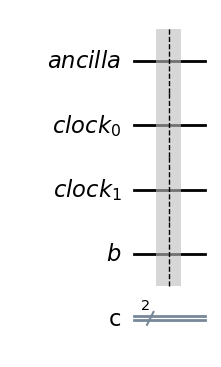

In [46]:
# Create the various registers needed
clock = QuantumRegister(2, name='clock')
input = QuantumRegister(1, name='b')
ancilla = QuantumRegister(1, name='ancilla')
measurement = ClassicalRegister(2, name='c')

# Create an empty circuit with the specified registers
qc = QuantumCircuit(ancilla, clock, input, measurement)

qc.barrier()
qc.draw(output='mpl')

In [60]:
def qft_dagger(circ: QuantumCircuit, q, n):      
    circ.h(clock[1])
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(-np.pi/float(2**(k-j)), q[k], q[j])
    circ.h(clock[0])
    circ.swap(clock[0], clock[1])

def qft(circ:QuantumCircuit, q, n):
    circ.swap(clock[0], clock[1]);
    circ.h(clock[0]);
    for j in reversed(range(n)):
      for k in reversed(range(j+1,n)):
        circ.cp(np.pi/float(2**(k-j)), q[k], q[j]);
    circ.h(clock[1]);

In [61]:
def qpe(circ, clock, target):
    qc.barrier()

    # e^{i*A*t}
    qc.cu(np.pi/2, -np.pi/2, np.pi/2, 3*np.pi/4, clock[0], input, label='U');
    
    # e^{i*A*t*2}
    qc.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    qc.barrier();
    
    # Perform an inverse QFT on the register holding the eigenvalues
    qft_dagger(qc, clock, 2)
    
def inv_qpe(circ, clock, target):
    
    # Perform a QFT on the register holding the eigenvalues
    qft(qc, clock, 2)

    qc.barrier()

    # e^{i*A*t*2}
    qc.cu(np.pi, np.pi, 0, 0, clock[1], input, label='U2');

    #circuit.barrier();

    # e^{i*A*t}
    qc.cu(np.pi/2, np.pi/2, -np.pi/2, -3*np.pi/4, clock[0], input, label='U');

    qc.barrier()

In [62]:
def hhl(circ, ancilla, clock, input, measurement):
    
    qpe(circ, clock, input)

    qc.barrier()
    
    # This section is to test and implement C = 1
    qc.cry(np.pi, clock[0], ancilla)
    qc.cry(np.pi/3, clock[1], ancilla)

    qc.barrier()
    
    qc.measure(ancilla, measurement[0])
    qc.barrier()
    inv_qpe(circ, clock, input)

In [63]:
# State preparation. 
intial_state = [0,1]
qc.initialize(intial_state, 3)

qc.barrier()

# Perform a Hadamard Transform
qc.h(clock)

hhl(qc, ancilla, clock, input, measurement)

# Perform a Hadamard Transform
qc.h(clock)

qc.barrier()


qc.measure(input, measurement[1])

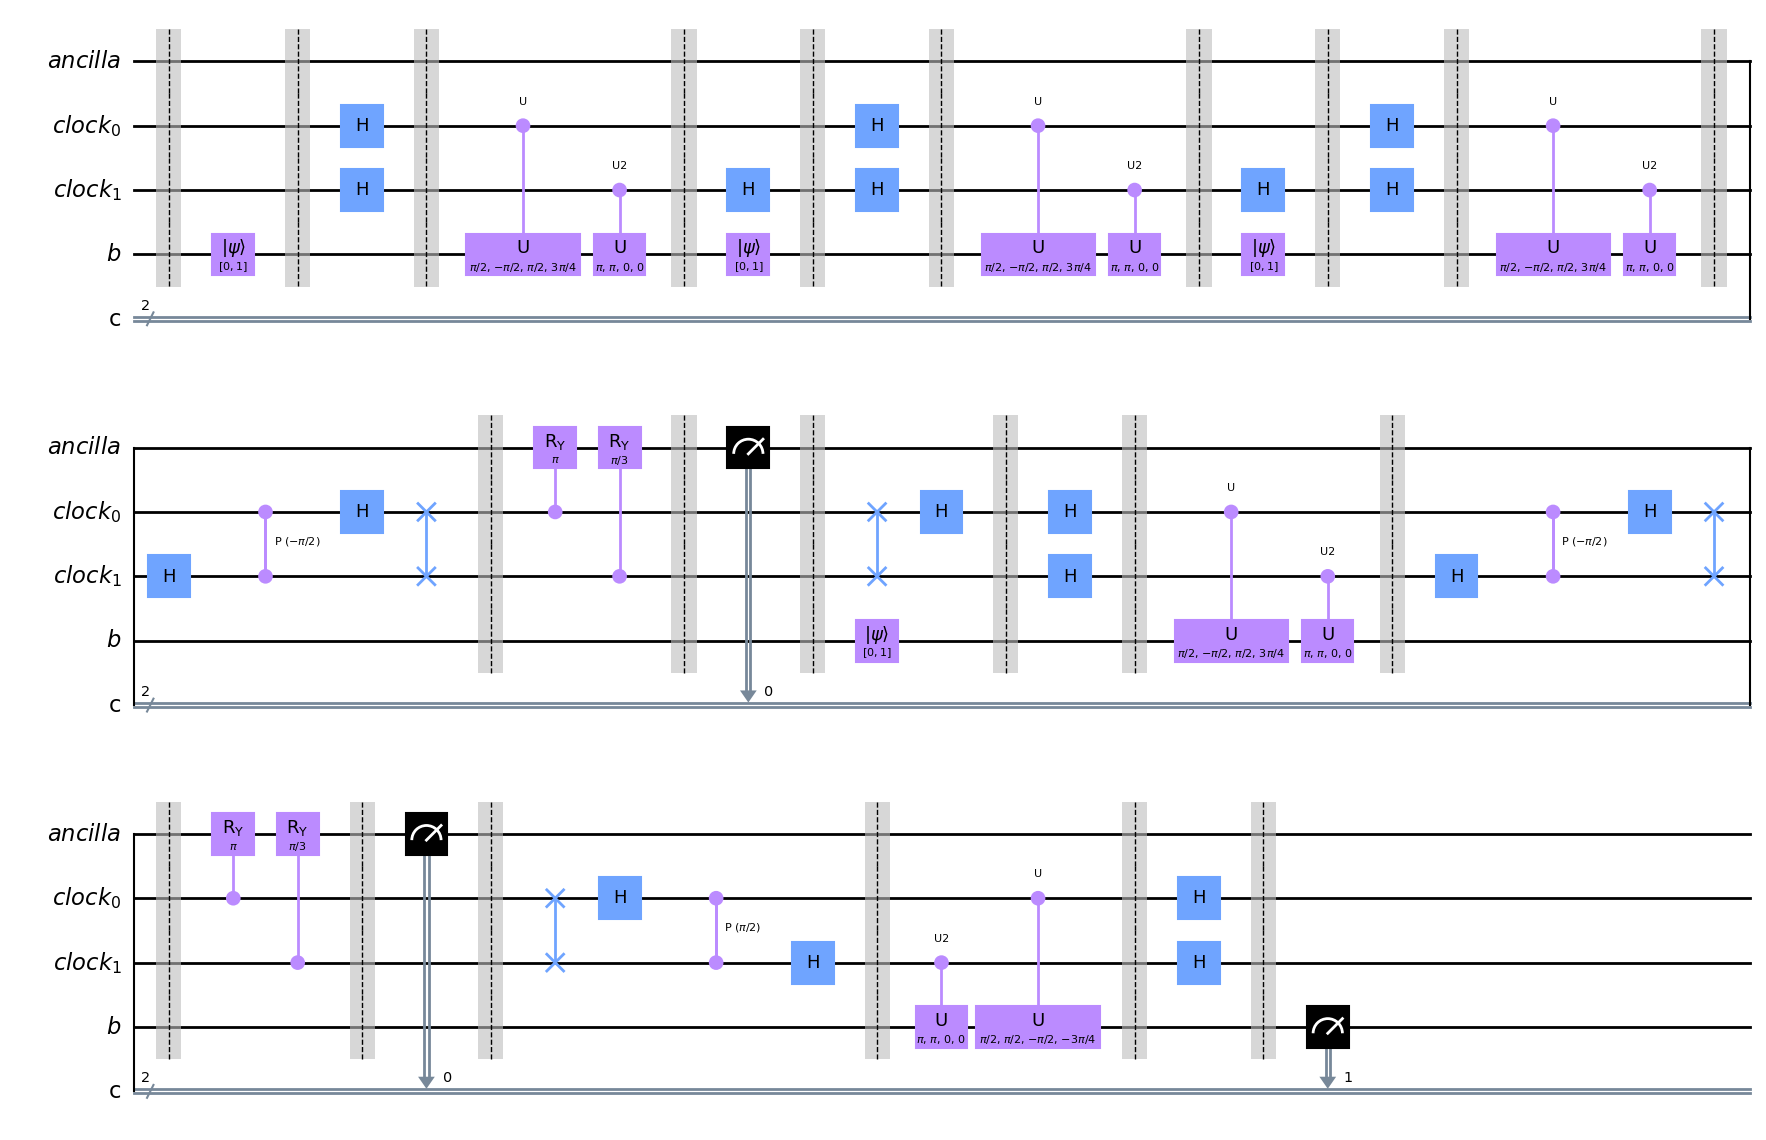

In [64]:
qc.draw('mpl',scale=1)

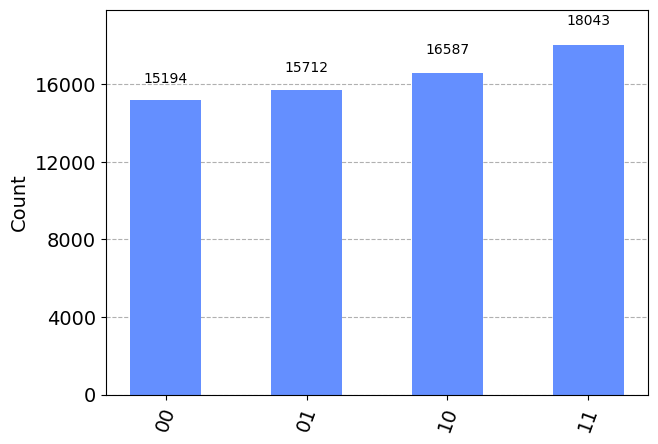

In [68]:
# Execute the circuit using the simulator
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=simulator, shots=65536)

#Get the result of the execution
result = job.result()

# Get the counts, the frequency of each answer
counts = result.get_counts(qc)

# Display the results
plot_histogram(counts)


In [69]:
bcknd = Aer.get_backend('statevector_simulator')

job_sim = execute(qc, bcknd)
result = job_sim.result()

o_state_result = result.get_statevector(qc, decimals=3)
print(o_state_result)

Statevector([ 0.   +0.j   ,  0.   +0.j   , -0.   +0.j   ,  0.   +0.j   ,
              0.   +0.j   ,  0.   +0.j   , -0.   +0.j   ,  0.   +0.j   ,
              0.247-0.j   ,  0.   +0.j   , -0.143+0.j   ,  0.   +0.j   ,
             -0.615-0.285j,  0.   +0.j   ,  0.615-0.285j,  0.   +0.j   ],
            dims=(2, 2, 2, 2))


In [70]:
provider.backends()

# Choose the backend on which to run the circuit
backend = provider.get_backend('ibmq_santiago')

# Execute the job
job_exp = execute(qc, backend=backend, shots=8192)


QiskitBackendNotFoundError: 'No backend matches the criteria'

In [ ]:
# Get the results from the computation
results = job_exp.result()

# Get the statistics
answer = results.get_counts(qc)

# Plot the results
plot_histogram(answer)